In [1]:
import pandas as pd
import numpy as np
import os
from bokeh.io import output_notebook, show
output_notebook()
import bokeh as bh
from sklearn.preprocessing import LabelEncoder
from glob import glob
import re
from math import ceil
import xgboost as xgb
from sklearn.model_selection import GroupKFold,KFold
import random
import operator
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
pd.options.display.max_columns = 1000

Loading BokehJS ...

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
os.chdir('C:/Users/pavan.velaga/Downloads')

C:\Users\pavan.velaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
data = pd.read_csv( "CAX_MortgageModeling_Train.csv")
submission_raw = pd.read_csv("CAX_MortgageModeling_Test.csv")

In [4]:
#data.head(10)

In [5]:
data['PROPERTY TYPE'].value_counts()

#High Rise<Townhouse Condominium<Townhouse Freehold<Semi-Detached<Single Detached<Duplex<Triplex<Fourplex
submission_raw['PAYMENT FREQUENCY'].value_counts()

Monthly                  14299
Bi-Weekly                  585
Bi-Weekly Accelerated      326
Weekly Accelerated           2
Weekly                       1
Semi-Monthly                 1
Name: PAYMENT FREQUENCY, dtype: int64

In [6]:

def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ( 'Day', 'Dayofweek', 'Month',
              'Is_month_end', 'Is_month_start'):
        df[targ_pre+n] = getattr(fld.dt, n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9

In [7]:
def feature_creation(df):
    df['anl_housing_exp'] = df['INCOME'] * df['GDS']
    df['appriesed_property_value'] = df['MORTGAGE AMOUNT']/df['LTV']
    df['other_expenses'] = (df['INCOME']*df['TDS']) - df['anl_housing_exp']
    df['property_apprl'] = df['appriesed_property_value']/df['PROPERTY VALUE']
    df['n_years'] = df['AMORTIZATION']/df['TERM']
    df['rate_property_apprl_yr'] = df['property_apprl']/df['n_years']
    df['rate_property_apprl_trm'] = df['property_apprl']/df['TERM']
    df['rate_property_apprl_amr'] = df['property_apprl']/df['AMORTIZATION']
    df['dipo_income'] = df['INCOME'] - df['other_expenses'] - df['anl_housing_exp']
    df['value_ratio'] = df['PROPERTY VALUE']/df['MORTGAGE AMOUNT']
    df['inc_mrg_rto'] = df['INCOME']/df['MORTGAGE AMOUNT']
    df['inc_py'] = df['INCOME']/df['n_years']
    df['montly_flg'] = np.where(df['PAYMENT FREQUENCY'] == 'Monthly',1,0)
    df['pt'] = (np.where(df['PROPERTY TYPE'] == 'High Rise',1,np.where(df['PROPERTY TYPE'] == 'Townhouse Condominium',2,
                np.where(df['PROPERTY TYPE'] == 'Townhouse Freehold',3, np.where(df['PROPERTY TYPE'] == 'Semi-Detached',4,
                np.where(df['PROPERTY TYPE'] == 'Single Detached',5,np.where(df['PROPERTY TYPE'] == 'Duplex',5
                ,np.where(df['PROPERTY TYPE'] == 'Triplex',6,np.where(df['PROPERTY TYPE'] == 'Fourplex',6,-1)))))))))
                                                                       
    return(df)

In [8]:
data = feature_creation(data)
submission_raw = feature_creation(submission_raw)

In [9]:
data.head(5)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,target,anl_housing_exp,appriesed_property_value,other_expenses,property_apprl,n_years,rate_property_apprl_yr,rate_property_apprl_trm,rate_property_apprl_amr,dipo_income,value_ratio,inc_mrg_rto,inc_py,montly_flg,pt
0,CAX_Train_301,301,3525000,15033,7.96,80.0,23.90,360,2820000.0,5.00,Purchase,Monthly,Single Detached,12,M5P,70 and over,Male,3860000,8,23,671,NOT FUNDED,1,30725600.0,35250.000000,61528400.0,0.010000,30.0,0.000333,0.000833,0.000028,-88394000.0,1.250000,1.368794,128666.666667,1,5
1,CAX_Train_15869,15869,3525000,13922,8.75,65.0,28.01,360,2820000.0,5.25,Purchase,Monthly,Single Detached,12,M5P,70 and over,Male,3860000,8,23,692,FUNDED,0,33775000.0,43384.615385,74343600.0,0.012308,30.0,0.000410,0.001026,0.000034,-104258600.0,1.250000,1.368794,128666.666667,1,5
2,CAX_Train_40049,40049,2600000,9709,6.88,65.0,30.69,360,1690000.0,4.75,Refinance,Monthly,Single Detached,12,M4R,30-34,Unknown,3430000,8,23,755,FUNDED,0,23598400.0,26000.000000,81668300.0,0.010000,30.0,0.000333,0.000833,0.000028,-101836700.0,1.538462,2.029586,114333.333333,1,5
3,CAX_Train_29403,29403,4300000,22149,7.12,75.0,17.06,300,3225000.0,5.75,Purchase,Monthly,High Rise,12,M4W,60-64,Male,2441000,8,53,823,NOT FUNDED,1,17379920.0,43000.000000,24263540.0,0.010000,25.0,0.000400,0.000833,0.000033,-39202460.0,1.333333,0.756899,97640.000000,1,1
4,CAX_Train_4672,4672,900000,3960,3.38,75.0,9.79,360,675000.0,5.00,Purchase,Monthly,Single Detached,12,L3P,45-49,Male,2400000,8,23,734,FUNDED,0,8112000.0,9000.000000,15384000.0,0.010000,30.0,0.000333,0.000833,0.000028,-21096000.0,1.333333,3.555556,80000.000000,1,5


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
data.columns


Index(['Unique_ID', 'MORTGAGE NUMBER', 'PROPERTY VALUE', 'MORTGAGE PAYMENT',
       'GDS', 'LTV', 'TDS', 'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE',
       'MORTGAGE PURPOSE', 'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'FSA',
       'AGE RANGE', 'GENDER', 'INCOME', 'INCOME TYPE', 'NAICS CODE',
       'CREDIT SCORE', 'RESULT', 'target', 'anl_housing_exp',
       'appriesed_property_value', 'other_expenses', 'property_apprl',
       'n_years', 'rate_property_apprl_yr', 'rate_property_apprl_trm',
       'rate_property_apprl_amr', 'dipo_income', 'value_ratio', 'inc_mrg_rto',
       'inc_py', 'montly_flg', 'pt'],
      dtype='object')

In [12]:
features = ['PROPERTY VALUE', 'MORTGAGE PAYMENT',
       'GDS', 'LTV', 'TDS', 'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE',
       'MORTGAGE PURPOSE', 'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'FSA',
       'AGE RANGE', 'GENDER', 'INCOME', 'INCOME TYPE', 'NAICS CODE','anl_housing_exp','appriesed_property_value'
            ,'property_apprl','dipo_income','value_ratio','inc_mrg_rto','pt','inc_py']
target = ['target']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.25, random_state=99)

In [14]:
for f in features:
    if X_train[f].dtype=='object':
        print(f+"-"+str(X_train[f].dtype))
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values) + list(submission_raw[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))
        submission_raw[f] = lbl.transform(list(submission_raw[f].values))

MORTGAGE PURPOSE-object
PAYMENT FREQUENCY-object
PROPERTY TYPE-object
FSA-object
AGE RANGE-object
GENDER-object
NAICS CODE-object


In [15]:
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features],label=y_test)



In [16]:
#num_rounds = 130
xgb_preds_lst = []
models = []
for i in ([0,199,10999]):
    watchlist = [(dtrain, 'train'), (dtest, 'val')]
    params = {'objective': 'binary:logistic',
              'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': 4,
              'max_depth': 5,
              'subsample': 0.8,
              'min_child_weight': 1,
              "colsample_bytree": 0.9,
              'eta': 0.05,
              'verbose_eval': True,
              'silent':1,
              'seed': i
              }

    clf_xgb = xgb.train(params, dtrain, num_boost_round=2000, verbose_eval=200, early_stopping_rounds=30, evals=watchlist)
    xgb_preds_lst.append(clf_xgb.predict(dtest))  
    
    models.append(clf_xgb)

[0]	train-auc:0.666229	val-auc:0.663969
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.802772	val-auc:0.74249
[400]	train-auc:0.855484	val-auc:0.749922
Stopping. Best iteration:
[392]	train-auc:0.853776	val-auc:0.750228

[0]	train-auc:0.673694	val-auc:0.656831
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.800471	val-auc:0.74154
[400]	train-auc:0.854093	val-auc:0.750464
Stopping. Best iteration:
[404]	train-auc:0.854983	val-auc:0.750635

[0]	train-auc:0.652019	val-auc:0.641689
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.802665	val-auc:0.742082
Stopping. Best iteration:
[310]	train-auc:0.835209	val-auc:0.746069



In [17]:
val_preds= [(xgb_preds_lst[0][i]+xgb_preds_lst[1][i]+xgb_preds_lst[2][i])/3 for i in range(len(xgb_preds_lst[1]))]


In [18]:
watchlist = [(dtrain, 'train'), (dtest, 'val')]
params = {'objective': 'binary:logistic',
              'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': 4,
              'max_depth': 5,
              'subsample': 0.8,
              'min_child_weight': 1,
              "colsample_bytree": 0.9,
              'eta': 0.05,
              'verbose_eval': True,
              'silent':1,
              'seed': 99
              }

clf_xgb = xgb.train(params, dtrain, num_boost_round=2000, verbose_eval=200, early_stopping_rounds=30, evals=watchlist)

[0]	train-auc:0.657583	val-auc:0.646446
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 30 rounds.
[200]	train-auc:0.800722	val-auc:0.739996
Stopping. Best iteration:
[363]	train-auc:0.84599	val-auc:0.748422



In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf_xgb,max_num_features=50, height=0.8, ax=ax)
plt.show()


<Figure size 1200x1800 with 1 Axes>

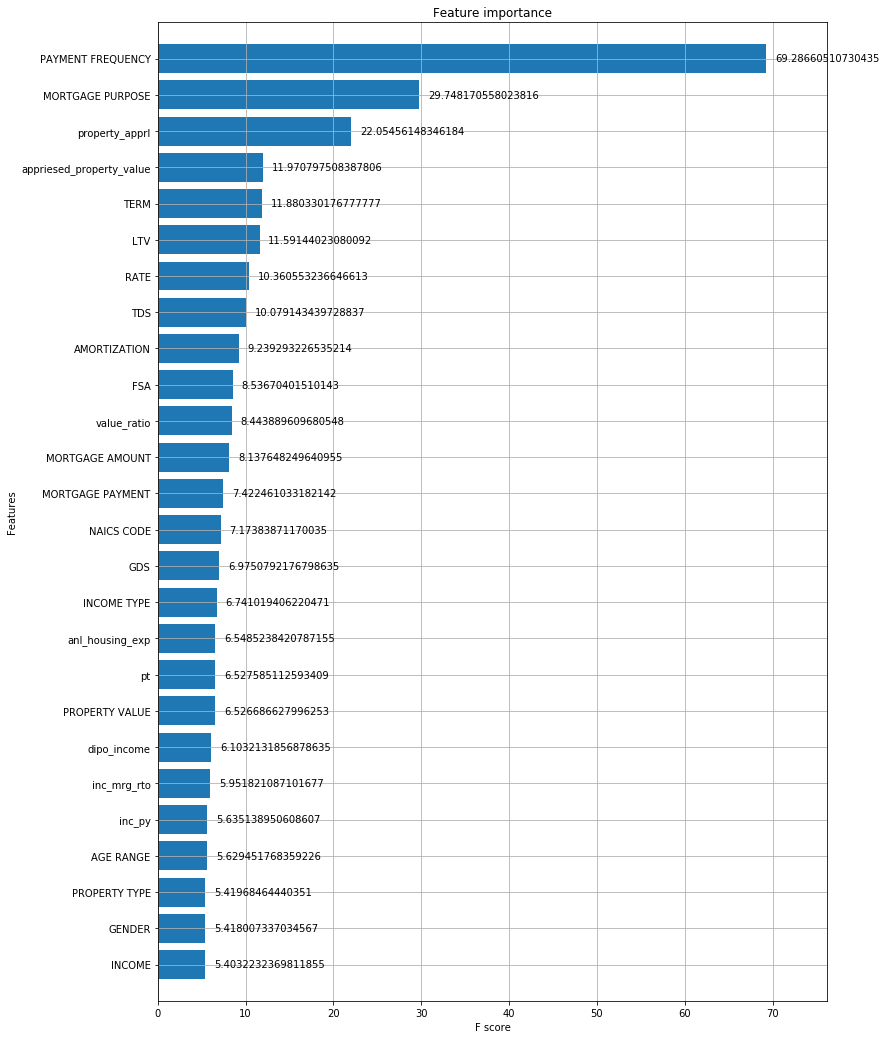

In [20]:

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf_xgb,importance_type= "gain", max_num_features=50, height=0.8, ax=ax)
plt.show()


In [21]:
importance = clf_xgb.get_score(importance_type='gain')
importance_df = pd.DataFrame(
    sorted(importance.items(), key=operator.itemgetter(1)), 
    columns=['feature','gain']
    )

In [22]:
class MetricsMeter():    
    def __init__(self, y_true, y_pred, threshold):
        self.y_true = y_true        
        self.y_pred = y_pred        
        self.thresh = threshold            
    
    def fit(self):        
        metrics = {}        
        metrics['auc'] = roc_auc_score(self.y_true, self.y_pred)                
        self.y_pred = [1 if x > self.thresh else 0 for x in self.y_pred]        
        metrics['f1'] = f1_score(self.y_true, self.y_pred,average = 'macro')        
        tn, fp, fn, tp = confusion_matrix(self.y_true, self.y_pred).ravel()                
        metrics['sensitivity/recall'] = tp / (tp+fn)
        metrics['precision'] = tp / (tp+fp)
        metrics["accuracy"] = (tp + tn) / (tp + fp + fn + tn)
        metrics['specificity'] = tn / (tn+fp)
        return metrics

In [23]:
val_preds = clf_xgb.predict(dtest)

In [24]:

dr_metrics = MetricsMeter(y_test, val_preds, i)
scores = dr_metrics.fit()    
scores['thresh'] = i    

C:\Users\pavan.velaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pavan.velaga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  


In [25]:
m = [] 
for i in np.linspace(0.01, 0.99, num=90):    
    dr_metrics = MetricsMeter(y_test, val_preds, i)
    scores = dr_metrics.fit()    
    scores['thresh'] = i    
    m.append(scores) 
m_build = pd.DataFrame(m)


# 

In [27]:
a = m_build.sort_values('f1', ascending=False)

In [28]:
a.head(10) #0.635282 #0.658185 #0.662413 #0.662483 ------ #0.658630 #0.661719  #0.662847 -- #0.666183

,accuracy,auc,f1,precision,sensitivity/recall,specificity,thresh
25,0.765665,0.748369,0.657974,0.450927,0.482231,0.841953,0.285281
26,0.772062,0.748369,0.657685,0.462213,0.457438,0.856746,0.296292
27,0.776531,0.748369,0.656193,0.470982,0.435950,0.868202,0.307303
28,0.781702,0.748369,0.655763,0.483006,0.416942,0.879880,0.318315
23,0.749715,0.748369,0.654208,0.427188,0.528512,0.809254,0.263258
24,0.756200,0.748369,0.654033,0.435125,0.501653,0.824714,0.274270
29,0.786084,0.748369,0.652803,0.494534,0.392562,0.892003,0.329326
22,0.738936,0.748369,0.650337,0.413921,0.555372,0.788344,0.252247
30,0.788625,0.748369,0.649258,0.502225,0.373140,0.900456,0.340337
31,0.793270,0.748369,0.648714,0.518253,0.357851,0.910466,0.351348


In [29]:
dsub = xgb.DMatrix(submission_raw[features])
predictions = []
for i in range(len(models)):
    predictions.append(models[i].predict(dsub))
submission_raw['probs'] = [(predictions[0][i]+predictions[1][i]+predictions[2][i])/3 for i in range(len(predictions[1]))]

In [30]:
submission_raw['Result_Predicted'] = np.where(submission_raw['probs']>0.285281,'NOT FUNDED','FUNDED')

In [31]:
inter_data = pd.concat([X_test,y_test],axis = 1) 
inter_data['preds'] = val_preds
 #inter_data = pd.concat([inter_data,np.array(val_preds)],axis = 1)

In [32]:
final_sub = submission_raw[['Unique_ID','Result_Predicted']]

In [33]:
final_sub['Result_Predicted'].value_counts()

FUNDED        11947
NOT FUNDED     3267
Name: Result_Predicted, dtype: int64

In [34]:
final_sub.to_csv('new_ft_sub13v.csv',index=False)

In [ ]:
#inter_data.to_csv('inter_data_probs.csv',index=False)

In [ ]:
#inter_data

In [ ]:
submission_raw.head(10)